# Loading and processing data

## Install requirements

In [1]:
!pip install -r ../requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


## Imports

In [2]:
# libraries
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
import json
%matplotlib inline
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import sys
sys.path.insert(0, "..")
from utils.dataprocessing_utils import *

%load_ext autoreload
%autoreload 2

## Configuration

In [3]:
# fbk config
fbk_data_dir = 'fbk/'
fbk_users = !ls fbk/*.pkl | grep -v prueba
fbk_users = [user.split('.pkl')[0].replace(fbk_data_dir, '') for user in fbk_users]
print('FBK participants: ' + str(fbk_users))

fbk_selected_users = ['355074057514446', '356508055384616', '356508055387676', '356508055388187', '356508055389532', '356508055393401', '356508055394433',
 '356508055394441', '356508055394516', '356508055394532', '356508055394714', '356508055394813', '356508055395216', '356508055395448', '356508055395513',
 '356508055395521', '356508055395596', '356508055396040', '356508055396479', '358307053878218']

fbk_start_date = pd.to_datetime('2013-11-01')
fbk_end_date = pd.to_datetime('2013-12-31')

fbk_columns = ['Answer']

# studentlife config
# data directories
sl_data_dir = '../../../../archive/research/datasets/studentlife/'

# emotional-related data
sl_stress_dir = 'EMA/response/Stress/'
sl_behavior_dir = 'EMA/response/Behavior/'
sl_darmouth_dir = 'EMA/response/Dartmouth now/'
sl_mood_dir = 'EMA/response/Mood/'

# workload-related data
sl_class_dir = 'EMA/response/Class/'
sl_class2_dir = 'EMA/response/Class 2/'
sl_lab_dir = 'EMA/response/Lab/'

# social-related data
sl_social_dir = 'EMA/response/Social/'
sl_events_dir = 'EMA/response/Events/'

# sleep-related data
sl_sleep_dir = 'EMA/response/Sleep/'

# ambient
sl_studyspaces_dir = 'EMA/response/Study Spaces/'

sl_conversation_dir = 'sensing/conversation/'

sl_start_date = pd.to_datetime('2013-03-20')
sl_end_date = pd.to_datetime('2013-06-26')

# users names
sl_users = !ls ../../../../archive/research/datasets/studentlife/EMA/response/Stress/*.json | grep -v prueba
sl_users = [user.split('.json')[0].replace(sl_data_dir+sl_stress_dir, '').split('_')[1] for user in sl_users]
sl_users_notselected = ['u00', 'u05', 'u09', 'u12', 'u20', 'u31', 'u34', 'u36', 'u39', 'u41', 'u42', 'u43', 'u45', 'u47', 'u50', 'u56']
print('StudentLife participants: ' + str(sl_users))

# define whether to include the change in the data or not
predict_change = False

# min_percentage of missing data admitted
fbk_max_percentages = [30, 45, 60, 75, 80]
sl_max_percentages = [30, 45, 60, 75, 80]

data_strategies = ['balanced', 'reliable']

FBK participants: ['355074057514446', '355136055159100', '356508055384616', '356508055387676', '356508055387684', '356508055388187', '356508055388278', '356508055389532', '356508055389953', '356508055393401', '356508055394433', '356508055394441', '356508055394508', '356508055394516', '356508055394532', '356508055394615', '356508055394714', '356508055394722', '356508055394813', '356508055395216', '356508055395414', '356508055395448', '356508055395505', '356508055395513', '356508055395521', '356508055395596', '356508055395646', '356508055396040', '356508055396479', '358307051348081', '358307053878218']
StudentLife participants: ['u00', 'u01', 'u02', 'u03', 'u04', 'u05', 'u07', 'u08', 'u09', 'u10', 'u12', 'u13', 'u14', 'u15', 'u16', 'u17', 'u18', 'u19', 'u20', 'u22', 'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36', 'u39', 'u41', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47', 'u49', 'u50', 'u51', 'u52', 'u53', 'u54', 'u56', 'u57', 'u58', 'u59']


## Load FBK Data

In [13]:
for fbk_max_missing_percentage in fbk_max_percentages:
    for data_strategy in data_strategies:
        fbk_data_array = []
        idx = pd.date_range(fbk_start_date, fbk_end_date)
        for uid in tqdm(fbk_users):
            data = pickle.load(open(f'{fbk_data_dir}{uid}.pkl', 'rb'))
            
            social_data = get_voice_data(data.copy())
            social_data = social_data[['duration']].reset_index().resample('D', on='Time').sum(numeric_only=True)
            
            data = select_columns(data, fbk_columns)

            # drop rows with NaN values
            data.dropna(inplace=True)

            # sort data by time
            data.sort_values(by='Time', inplace=True)

            data = convert_to_hourly(data)
            
            data['stress'], data['sleep'], data['something_good'], data['something_else'], data['effective'], data['effort'], data['current_activity'], data['energetic']= zip(*data['Answer'].map(parse_fbk_answers))
            data.drop(['Answer'], axis = 1, inplace=True)
            
            data = data[['stress', 'sleep', 'effort']]
            data.columns = ['stress', 'sleep', 'workload']
            data['sleep'] = data['sleep'].astype('float64')
            data['workload'] = data['workload'].astype('float64')
            data.reset_index(inplace=True)
            data = data.resample('D', on='date').mean(numeric_only=True).round()

            data = data.merge(social_data, how='left', left_index=True, right_index=True)

            data = filter_by_week(data.reindex(idx), 'fbk', data_strategy)
            
            percent_missing = data.isnull().sum() * 100 / len(data)
            if percent_missing['stress'] > fbk_max_missing_percentage or data['stress'].isnull().all() or data['workload'].isnull().all() or data['sleep'].isnull().all() or data['duration'].isnull().all():
                continue

            data = data.interpolate(method='nearest').ffill().bfill().round()

            if predict_change:
                data['curr_change'] = data['stress'] - data['stress'].shift(1)
                data['curr_change'] = data['curr_change'].apply(lambda x: 1 if x > 1 else x)
                data['curr_change'] = data['curr_change'].apply(lambda x: -1 if x < -1 else x)
                data['next_change'] = data['stress'].shift(-1) - data['stress']
                data['next_change'] = data['next_change'].apply(lambda x: 1 if x > 1 else x)
                data['next_change'] = data['next_change'].apply(lambda x: -1 if x < -1 else x)
                data.dropna(inplace=True)
            
            data = data.astype(int)
            data['user'] = 'u' + str(len(fbk_data_array) + 1)    

            fbk_data_array.append(data)

        for cut_strategy in ['cut', 'notcut']:
            fbk_data = pd.concat(fbk_data_array)
            fbk_data.set_index('user', append=True, inplace=True)
            fbk_data.index.names = ['date', 'user']
            fbk_data['stress'] = pd.cut(fbk_data['stress'], bins=3, labels = [1, 2, 3])
            fbk_data['stress'] = fbk_data['stress'].astype(int)
            if cut_strategy == 'cut':
                fbk_data['voice'] = pd.qcut(fbk_data['duration'], q=3, labels = [1, 2, 3])
                fbk_data['voice'] = fbk_data['voice'].astype(int)
                fbk_data['workload'] = pd.cut(fbk_data['workload'], bins=3, labels = [1, 2, 3])
                fbk_data['workload'] = fbk_data['workload'].astype(int)
                fbk_data['sleep'] = pd.cut(fbk_data['sleep'], bins=3, labels = [1, 2, 3])
                fbk_data['sleep'] = fbk_data['sleep'].astype(int)
            else:
                fbk_data['voice'] = pd.qcut(fbk_data['duration'], q=5, labels = [1, 2, 3, 4, 5])
                fbk_data['voice'] = fbk_data['voice'].astype(int)
            fbk_data.to_csv('processed/fbk_processed_data_{}_{}_{}.csv'.format(fbk_max_missing_percentage, data_strategy, cut_strategy))
        

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

## Load StudentLife data

In [5]:
for sl_max_missing_percentage in sl_max_percentages:
    for data_strategy in data_strategies:
        sl_data_array = []
        idx = pd.date_range(sl_start_date, sl_end_date)
        for uid in sl_users:

            # create empty dataframe whose index are the dates between the start and end dates
            dates = pd.DataFrame(index=pd.date_range(sl_start_date, sl_end_date))

            with open(sl_data_dir+sl_stress_dir+'Stress_'+uid + '.json') as json_file:
                a_json = json.load(json_file)
                stress_data = get_sl_stress_data(a_json)
                if stress_data is None:
                    stress_data = pd.DataFrame(index=dates.index, columns = ['stress'])
            
            with open(sl_data_dir+sl_class_dir+'Class_'+uid + '.json') as json_file:
                a_json = json.load(json_file)
                class_data = get_sl_class_data(a_json)
                if class_data is None:        
                    class_data = pd.DataFrame(index=dates.index, columns = ['hours_worked', 'enjoyed_class'])

            with open(sl_data_dir+sl_sleep_dir+'Sleep_'+uid + '.json') as json_file:
                a_json = json.load(json_file)
                sleep_data = get_sl_sleep_data(a_json)
                if sleep_data is None:
                    sleep_data = pd.DataFrame(index=dates.index, columns = ['sleep_hours', 'sleep_rate'])  

            result = dates.join(stress_data, how='outer')
            result = result.join(class_data, how='outer')
            result = result.join(sleep_data, how='outer')
        
            result.replace('null', np.NaN, inplace=True)
            result.dropna(how='all', inplace=True)
            
            result['hours_worked'] = result['hours_worked'].astype('float64')
            result['sleep_rate'] = result['sleep_rate'].astype('float64')
            result['stress'] = result['stress'].astype('float64')

            result.reset_index(inplace=True)
            result = result.resample('D', on='index').mean(numeric_only=True)
            
            voice_data = pd.read_csv(sl_data_dir+sl_conversation_dir+'conversation_' + uid + '.csv')
            voice_data = get_sl_voice_data(voice_data)[['date', 'duration']]
            voice_data = voice_data.resample('D', on='date').sum(numeric_only=True)
            result = result.merge(voice_data, how='left', left_index=True, right_index=True)

            result = result.dropna(how='any', subset=['stress'])[['stress', 'hours_worked', 'sleep_rate', 'duration']]
            
            result = filter_by_week(result.reindex(idx), 'sl', data_strategy)
            
            percent_missing = result.isnull().sum() * 100 / len(result)

            if percent_missing['stress'] > sl_max_missing_percentage or result['stress'].isnull().all() or result['hours_worked'].isnull().all() or result['sleep_rate'].isnull().all() or result['duration'].isnull().all():
                continue

            result = result.interpolate(method='nearest').ffill().bfill().round().astype(int)

            # check if all the rows are NaN
            if result.isnull().all().all():
                continue

            result.columns = ['stress', 'workload', 'sleep', 'duration']
            
            if predict_change:
                result['curr_change'] = result['stress'] - result['stress'].shift(1)
                result['curr_change'] = result['curr_change'].apply(lambda x: 1 if x > 1 else x)
                result['curr_change'] = result['curr_change'].apply(lambda x: -1 if x < -1 else x)
                result['next_change'] = result['stress'].shift(-1) - result['stress']
                result['next_change'] = result['next_change'].apply(lambda x: 1 if x > 1 else x)
                result['next_change'] = result['next_change'].apply(lambda x: -1 if x < -1 else x)
                result.dropna(inplace=True)

            result = result.astype(int)
            result['user'] = uid

            sl_data_array.append(result)
        sl_data = pd.concat(sl_data_array)
        sl_data.set_index('user', append=True, inplace=True)
        sl_data.index.names = ['date', 'user']
        sl_data['voice'] = pd.cut(sl_data['duration'], bins=5, labels = [1, 2, 3, 4, 5])
        sl_data['voice'] = sl_data['voice'].astype(int)
        sl_data['workload'] = pd.cut(sl_data['workload'], bins=5, labels = [1, 2, 3, 4, 5])
        sl_data['workload'] = sl_data['workload'].astype(int)
        sl_data.to_csv('processed/sl_processed_data_{}_{}.csv'.format(sl_max_missing_percentage, data_strategy))

## Data visualization

In [6]:
fbk_data.corr()

,stress,sleep,workload,duration,voice
stress,1.000000,-0.200482,0.389577,0.017693,-0.015211
sleep,-0.200482,1.000000,-0.058211,-0.089298,-0.084753
workload,0.389577,-0.058211,1.000000,0.000675,-0.047913
duration,0.017693,-0.089298,0.000675,1.000000,0.808439
voice,-0.015211,-0.084753,-0.047913,0.808439,1.000000


In [7]:
sl_data.corr()

,stress,workload,sleep,duration,voice
stress,1.000000,0.069716,-0.104995,0.040647,0.022216
workload,0.069716,1.000000,-0.078003,-0.127277,-0.130634
sleep,-0.104995,-0.078003,1.000000,-0.068075,-0.060336
duration,0.040647,-0.127277,-0.068075,1.000000,0.953484
voice,0.022216,-0.130634,-0.060336,0.953484,1.000000


In [8]:
sl_data=(sl_data-sl_data.mean())/sl_data.std()
sl_poly_stress = np.polyfit(list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])), sl_data['stress'].reset_index().groupby('date').mean(numeric_only=True), deg=5)
sl_poly_workload= np.polyfit(list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])), sl_data['workload'].reset_index().groupby('date').mean(numeric_only=True), deg=5)
sl_poly_sleep = np.polyfit(list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])), sl_data['sleep'].reset_index().groupby('date').mean(numeric_only=True), deg=5)
sl_poly_duration = np.polyfit(list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])), sl_data['duration'].reset_index().groupby('date').mean(numeric_only=True), deg=5)

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Stress'),
 (-0.5, 0.5),

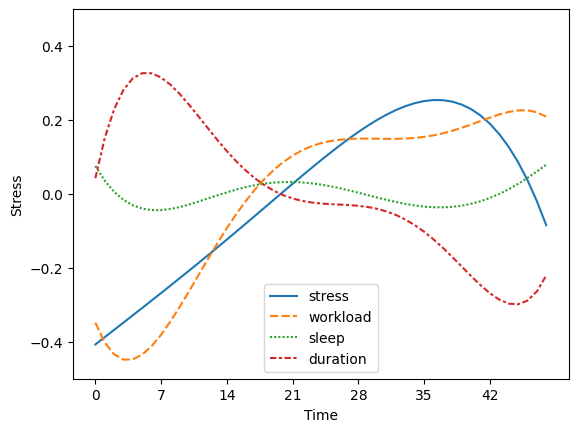

In [9]:
sl_poly_data = pd.DataFrame(index=list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))
sl_poly_data['stress'] = np.polyval(sl_poly_stress, list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))
sl_poly_data['workload'] = np.polyval(sl_poly_workload, list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))
sl_poly_data['sleep'] = np.polyval(sl_poly_sleep, list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))
sl_poly_data['duration'] = np.polyval(sl_poly_duration, list(range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))

g = sns.lineplot(data=sl_poly_data)
g.set(xlabel='Time', ylabel='Stress', ylim=(-0.5, 0.5),xticks=range(0, sl_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0], 7))

In [10]:
fbk_data=(fbk_data-fbk_data.mean())/fbk_data.std()
fbk_poly_stress = np.polyfit(list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])), fbk_data['stress'].reset_index().groupby('date').mean(numeric_only=True), deg=5)
fbk_poly_workload= np.polyfit(list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])), fbk_data['workload'].reset_index().groupby('date').mean(numeric_only=True), deg=5)
fbk_poly_sleep = np.polyfit(list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])), fbk_data['sleep'].reset_index().groupby('date').mean(numeric_only=True), deg=5)
fbk_poly_duration = np.polyfit(list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])), fbk_data['duration'].reset_index().groupby('date').mean(numeric_only=True), deg=5)

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Stress'),
 (-0.2, 0.2),

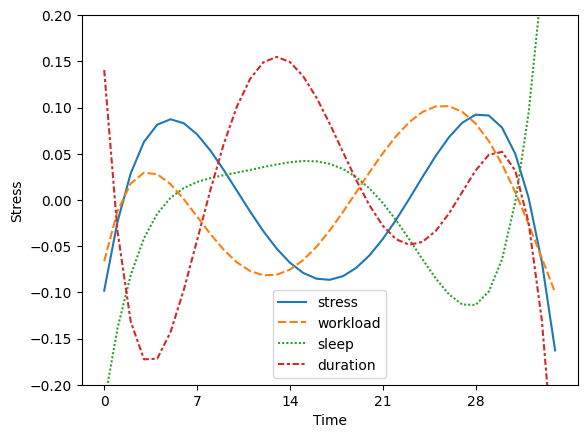

In [11]:
fbk_poly_data = pd.DataFrame(index=list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))
fbk_poly_data['stress'] = np.polyval(fbk_poly_stress, list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))
fbk_poly_data['workload'] = np.polyval(fbk_poly_workload, list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))
fbk_poly_data['sleep'] = np.polyval(fbk_poly_sleep, list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))
fbk_poly_data['duration'] = np.polyval(fbk_poly_duration, list(range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0])))

g = sns.lineplot(data=fbk_poly_data)
g.set(xlabel='Time', ylabel='Stress', ylim=(-0.2, 0.2),xticks=range(0, fbk_data.reset_index().groupby('date').mean(numeric_only=True).index.shape[0], 7))